### Juan David Orjuela - Sofía Álvarez López

In [43]:
%load_ext tensorboard
%pylab inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Populating the interactive namespace from numpy and matplotlib


In [44]:
# ESAI
import os
import cv2
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline, FeatureUnion
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

<h1 align = 'center'>Laboratorio 3: Machine Learning Techniques</h1>

## Problema 

Ante la situación actual de sanidad pública en el mundo a causa del COVID-19. La detección temprana de esta enfermedad en los pacientes, la automatización de procesos de diagnóstico y el apoyo a los diferentes expertos de esta enfermedad juega un papel muy importante para enfrentar una pandemia el cual ha registrado más de 230 millones de contagios, dejando sin vida a 4 millones de personas alrededor del mundo (OMS, 2021).

Sin embargo, todo este tiempo de cuarentena no solo ha servido para frenar la tasa de contagio del virus. También nos ha permitido recolectar diferentes radiografias de pacientes quienes han sufrido esta enfermedad, junto a otras enfermedades que pueden llegar a tener un una confusión con la enfermedad provocada por el virus. Por ello, es importante determinar con exactitud el tipo de enfermedad para poder recomendar el mejor tratamiento para el paciente.

Se han recolectado alrededor de 21 mil imágenes provenientes de diferentes paises del medio oriente como Catar, Pakistan y Malasia. Y, ante la reactivación económica que se quiere llevar a cabo, se teme una nueva ola de contagios, por lo que poder identificar estos casos dadas sus radiografías autmáticamente, sería de gran ayuda para los trabajadores de la Salud para determinar el tratamiento a los pacientes.

Para eso, le han pedido que construya un modelo capaz de recibir esas imágenes y determinar bajo que probabilidad puede pertenecer a cada una de las clases de las enfermedades proporcionadas. Y así mismo determinar cuál sería el diagnóstico de ese paciente. Como sugerencia, le han pedido construir una Red Neuronal Artificial (ANN) la cual permita realizar este proceso de manera automática y sin supervisión de los expertos en el tema.

Finalmente, Ante la urgencia del problema, le han pedido que utilicen las imágenes en escala de grises para poder realizar una carga y un almacenamiento de manera más óptima, y utilizar directamente como entrada esta imagen.

## Exploración y descripción de los datos
Lo primero que hacemos es explorar los datos de nuestro dataset. Notamos que este se compone de cuatro carpetas:

In [3]:
directorio = r'COVID-19_Radiography_Dataset'
print(os.listdir(directorio))

['.DS_Store', 'Viral Pneumonia', 'Lung_Opacity', 'Normal', 'COVID']


De acuerdo con el enunciado del problema, estos corresponden a las 4 clases que debemos estudiar: una categoría corresponde a las imágenes por COVID, las otras dos por otro tipo de enfermedades respiratorias: pneumonía viral y opacidad pulmonar. Finalmente, tenemos las radiografías de pacientes no enfermos: i.e. la categoría normal. <i>A priori</i>, esperamos que esta sea la clase con mayor cantidad de imágenes. Veamos la distribución de las clases:

In [4]:
# Creamos un dataframe con la ruta del archivo y la etiqueta de clase de la enfermedad a la que corresponde
rutas_archivos = []
etiquetas = []
clases = os.listdir(directorio)
for c in clases:
    ruta_clase = os.path.join(directorio,c)
    if os.path.isdir(ruta_clase):
        lista_archivos = os.listdir(ruta_clase)
        for archivo in lista_archivos:
            ruta_archivo = os.path.join(ruta_clase, archivo)
            rutas_archivos.append(ruta_archivo)
            etiquetas.append(c)                   
archivos = pd.Series(rutas_archivos, name='Ruta imagen')
etiquetas = pd.Series(etiquetas, name='Enfermedad')    
df=pd.concat([archivos, etiquetas], axis=1)
df.sample(5)

,Ruta imagen,Enfermedad
21130,COVID-19_Radiography_Dataset/COVID/COVID-2883.png,COVID
3933,COVID-19_Radiography_Dataset/Lung_Opacity/Lung...,Lung_Opacity
10242,COVID-19_Radiography_Dataset/Normal/Normal-500...,Normal
1264,COVID-19_Radiography_Dataset/Viral Pneumonia/V...,Viral Pneumonia
14212,COVID-19_Radiography_Dataset/Normal/Normal-978...,Normal


Ahora, miramos cuantas imágenes hay en cada clase:

In [5]:
print(df['Enfermedad'].value_counts())

Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: Enfermedad, dtype: int64


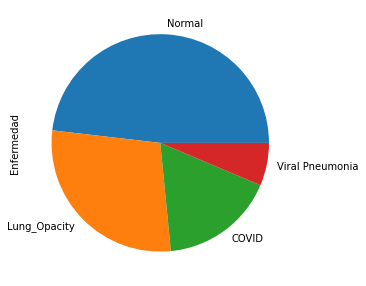

In [6]:
plot = df['Enfermedad'].value_counts().plot.pie(y='Enfermedad', figsize=(5, 5))

Asimismo, obtenemos el número total de imágenes del dataset:

In [7]:
print('Total de imágenes en el dataset:', sum(df['Enfermedad'].value_counts()))

Total de imágenes en el dataset: 21165


Como esperábamos, el conjunto de datos no está balanceado. Debemos tener esto en cuenta posteriormente cuando hayamos partido los datos en entrenamiento y test y debamos tomar decisiones sobre cómo balancearlo, para construir el mejor modelo posible.

Ahora, procedemos a partir el conjunto de datos en train y test. Usualmente, usamos una división 80%$-$20% para entrenamiento y test, respectivamente. No obstante, debido a que tenemos en total 21.165 imágenes (i.e. son bastantes) podemos tomar una partición 90%$-$10%. Así, tendríamos 19.048 en train y 2117 imágenes en test. Lo anterior, con el fin de tener una mayor cantidad de imágenes para entrenar nuestro modelo: por lo general es preferible tener muchos datos. De hecho, según lo visto en clase, una de las mejores formas de evitar/disminuir el <i>overfitting</i> es aumentando la cantidad de datos en el conjunto de entrenamiento. Afortunadamente, en este dataset podemos darnos ese lujo. Posteriormente, guardamos el test en la caja fuerte.

In [8]:
train_df, test_df =train_test_split(df,test_size=0.1, shuffle=True, random_state=28)
X_train, Y_train = train_df['Ruta imagen'], train_df['Enfermedad']

Veamos algunas de las imágenes de nuestro conjunto de datos antes de proceder con el preprocesamiento:

(299, 299, 3)


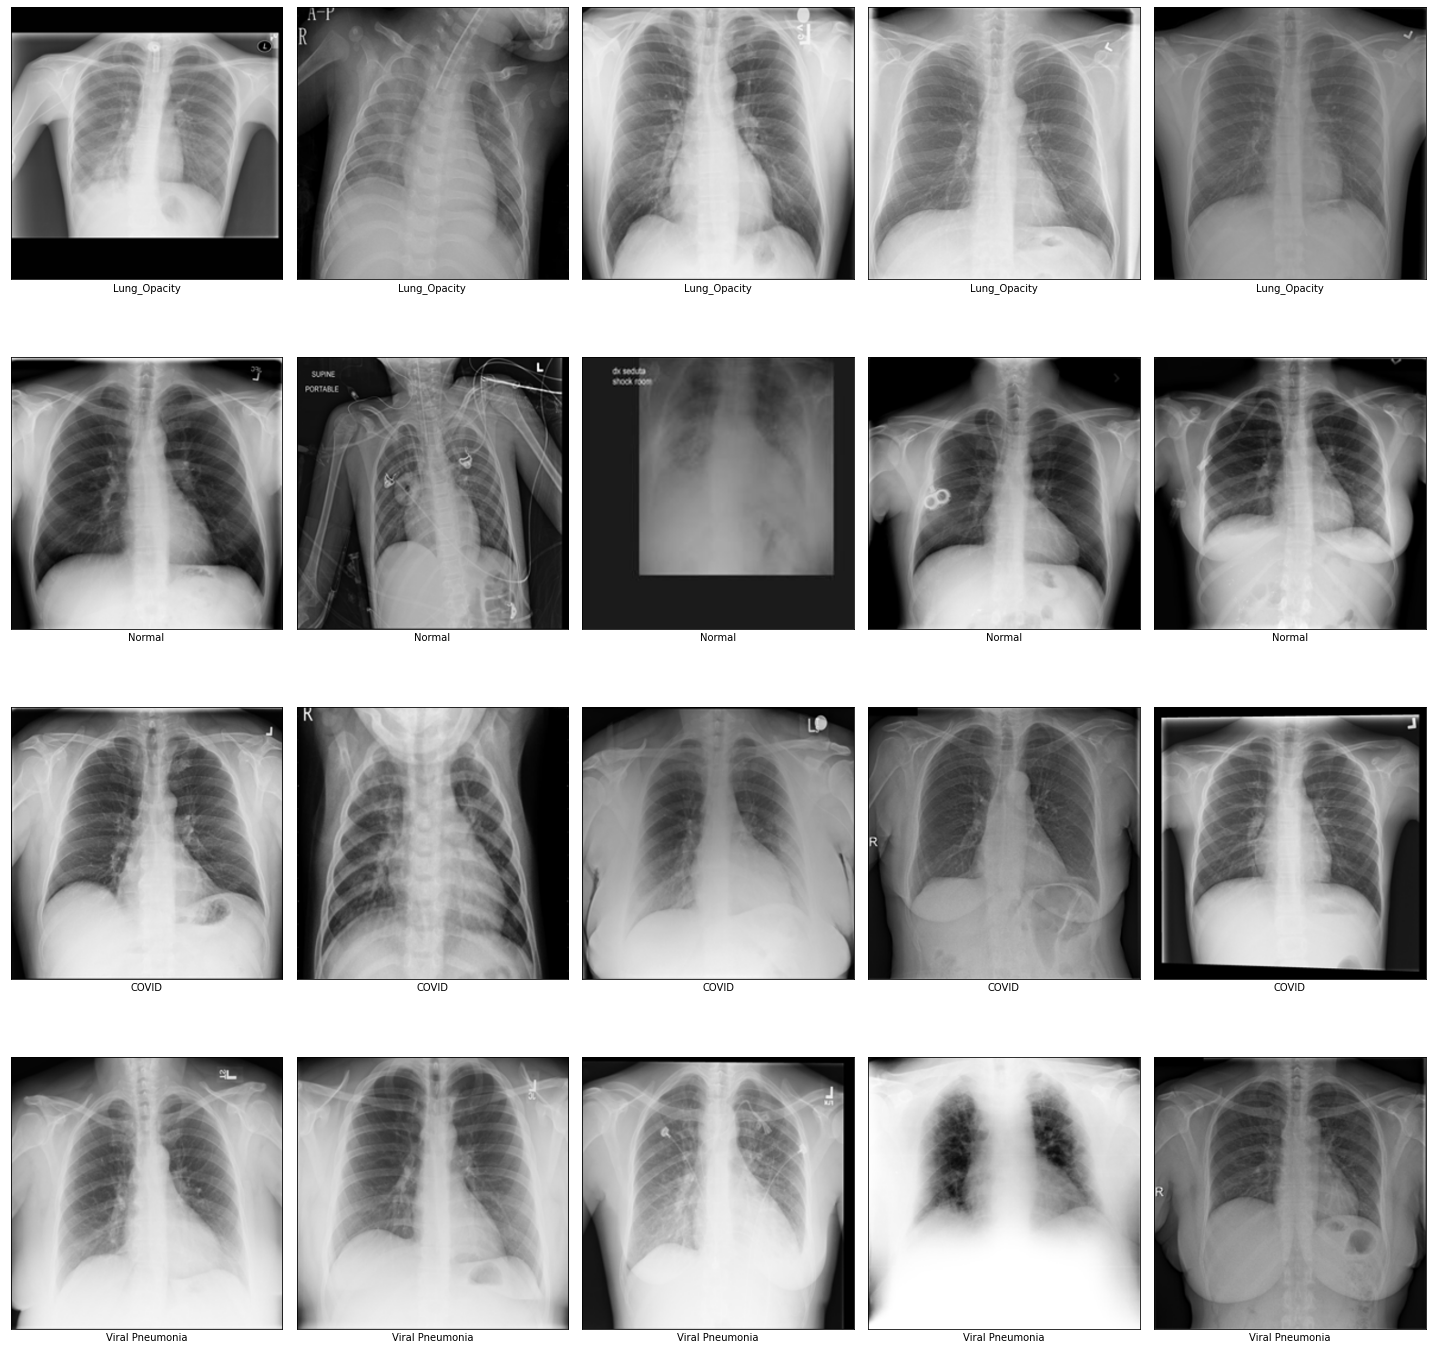

In [9]:
fig, axs = plt.subplots(len(list(Y_train.unique())), 5, figsize = (20, 20))

class_len = {}

for i, c in enumerate(list(Y_train.unique())):
    sample_images = random.sample(list(X_train), 5)
    
    for j, image in enumerate(sample_images):
        img = cv2.imread(image)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = c, xticks = [], yticks = [])
print(img.shape)

fig.tight_layout()

Aquí podemos ver 5 imágenes correspondientes a cada una de las categorías que tenemos en nuestro dataset. Las imágenes están en tonos grisáceos. No obstante, debemos convertirlas a la escala de grises que el enunciado recomienda, es decir, para que queden en un sólo canal. Note que el tamaño de las imágenes es (299,299,3). El 3 del final significa que aún está en RGB.


Procedemos entonces a realizar el preprocesamiento de las imágenes sugerido por el enunciado.



## Preprocesamiento
Hay dos puntos fundamentales que debemos considerar en el preprocesamiento de imágenes. Sabemos que este varía de acuerdo con el tipo de arquitectura de red neuronal a utilizar. En este caso, la primera decisión que debemos tomar es aquella relacionada con el balanceo de las clases. Como vimos en la exploración, tenemos **muchas** imágenes correspondientes a las clases normales, y, en comparación con ella, pocas de las de las enfermedades.

Una opción sería reducir el conjunto de datos hasta que todas las clases queden con un número de imágenes igual al tamaño de la clase de menor cantidad de imágenes. No obstante, por lo general la idea es no reducir el conjunto de datos. Lo que sí podemos hacer es considerar pesos. Así, el modelo podrá prestar mayor atención a las clases minoritarias.

Ahora cargamos todas las imágenes. En la parte anterior, únicamente revisamos aspectos relacionados con las labels y visualizamos algunas imágenes aleatorias. Ahora sí las cargamos, respetando la partición 90%$-$10% entre train y test, respectivamente, como habíamos definido previamente, pues únicamente tenemos train_df en este punto.

Asimismo, usamos las imágenes en escala de grises, según nos sugiere hacer el enunciado, por medio del parámetro <code>color_mode='grayscale'</code>. Este pedazo es fundamental, pues determina cuántos canales (en este caso, 1) tendrá la imagen. Asimismo, utilizamos <code>class_mode='categorical'</code> que lo que hace es darnos OneHot-Encoding para nuestro modelo.

Cabe aclarar que, en el objeto <code>ImageDataGenerator</code> de Keras, podemos incluir algunos métodos para realizar <code>ImageAugmentation</code>. No obstante, como por la urgencia de la emergencia se nos pide únicamente usar escala de grises y aplanar las imágenes, nos ceñimos únicamente a eso. Cabe aclarar que algo que sí hacemos es reescalar las imágenes por un factor de 1./255. Esto se hace pues todas las imágenes comparten el mismo modelo, pesos y tasa de aprendizaje. De hecho, escalar todas las imágenes al mismo rango [0,1], al multiplicar por 1./255, hará que las imágenes contribuyan más uniformemente a la pérdida total [2].

In [10]:
datagen_train = ImageDataGenerator(
    rescale = 1./255,
) 

train_generator = datagen_train.flow_from_dataframe(
    train_df,
    x_col='Ruta imagen', 
    y_col='Enfermedad',
    class_mode='categorical',
    color_mode='grayscale',
    classes = list(train_df['Enfermedad'].unique()),
    batch_size = 500, # Un lote tan grande como se pueda, pero que no nos deje sin memoria
    target_size = (299,299), # Este es el tamaño de las imagenes del data set, como vimos mas arriba
    seed=28,
    shuffle = True,
    subset = 'training'
)

Found 19048 validated image filenames belonging to 4 classes.


Podemos ver que las clases son consistentes con lo que habíamos visto en exploración

In [11]:
train_generator.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

Ahora, implementamos los pesos, usando la librería apropiada de <code>scikit-learn</code>:

In [12]:
class_weights = class_weight.compute_class_weight(
                class_weight = 'balanced',
                classes = np.unique(train_generator.classes), 
                y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

Podemos ver los pesos asociados a las clases 0, 1, 2 y 3 respectivamente:

In [13]:
class_weights

array([1.4593932 , 0.87892211, 0.51964208, 3.95843724])

Como era de esperarse, la clase que tiene más peso es la minoritaria: i.e. la correspondiente a pneumonía viral, seguida por COVID. Note que esto coincide con los porcentajes de datos que obtuvimos al comienzo, de acuerdo con la *pie chart* que hicimos.

Con esto, ya estamos casi listos. Únicamente nos faltaría aplanar las imágenes. No obstante, para ello podemos usar la capa <code>Flatten</code> de Keras, la cual aplana la entrada (en este caso, la imagen, como queremos). Esto lo haremos en el siguiente paso: modelamiento.

No obstante, antes de ello, veamos un ejemplo de cómo quedó una imágenes y revisemos su tamaño. Por defecto, <code>Tensorflow</code> ajusta el tamaño a 256$\times$256. Podemos ver que queda un solo canal (correspondiente al último índice del tamaño de la imagen) Asimismo, vemos que el primer índice corresponde al tamaño del batch utilizado.

(500, 299, 299, 1)


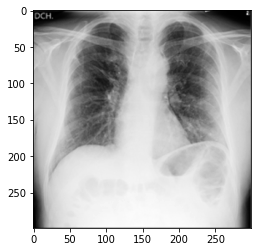

In [14]:
for _ in range(1):
    img, label = train_generator.next()
    print(img.shape)   
    plt.imshow(img[0],cmap='gray')
    plt.show()

La tupla (500, 256, 256, 1) quiere decir que, para cada batch de tamaño 500, cada imagen será de dimensiones (299,299,1). Conservamos las dimensiones de la imagen original, pero redujimos de 3 canales a 1. 

## Modelamiento
Sabemos que hay muchas arquitecturas de redes neuronales. En particular, para imágenes, suelen usarse las redes neuronales convolucionales. Estas no las hemos visto a cabalidad en clase. De hecho, la arquitectura de solución que sugiere el enunciado pide "aplanar" la imagen, paso que no es necesario para las CNN. 

Por esta razón, preferimos realizar la ANN correspondiente a un MLP. Es decir, un Multilayer Perceptron. Empezamos por crear el modelo, luego ajustamos sus hiperparámetros. Note que algunas de las cosas que hicimos en preprocesamiento pueden ser hiperparámetros (por ejemplo, el tamaño del batch). No obstante, no los tenemos en cuenta pues el enfoque de las clases aún no ha estado orientado a realizar preprocesamiento en imágenes.

---
Consideremos primero un modelo con una sola capa oculta, de 512 neuronas que se constituirá en nuestro baseline. Después, haciendo ajuste de hiperparámetros, esperamos encontrar modelos que clasifiquen de forma superior. Para las Redes Neuronales, siempre es fundamental especificar la dimensión de entrada y la dimensión de la salida esperada pues definen parcialmente el tamaño y estructura de la ANN:

In [15]:
output = 4 # Pues tenemos 4 clases de clasificación


# Inicializamos el modelo
model_mlp = Sequential()
# Agregamos la capa de Flattening 
model_mlp.add(Flatten(input_shape=(299,299,1))) # Tomamos este input shape porque es el tamanio de nuestras imagenes
# Agregamos la primera capa, con su funcion de activacion respectiva
model_mlp.add(Dense(512, activation='relu'))
# Definimos la tasa de dropout
model_mlp.add(Dropout(0.5))
# Definimos la capa de salida
model_mlp.add(Dense(output, activation='softmax'))

Antes de ver nuestro modelo totalmente construido, conviene discutir un poco lo que acabamos de hacer.
Inicializamos el modelo creando un modelo secuencial. Posteriormente, agregamos una capa de aplanamiento con el fin de convertir las imágenes en arreglos unidimensionales, que son las entradas que reciben los MLP. Más adelante, ponemos nuestra primera (y única) capa oculta. Aquí, justificamos algunas de nuestras decisiones:
* **¿Por qué ReLu?** De acuerdo con la literatura, la función ReLu es la más utilizada en aplicaciones de Machine Learning. En la práctica, además, tiende a tener mejor convergencia que la sigmoide o la tanh [3]. Asimismo, la función de activación ReLu es la que corre en el menor tiempo de cómputo (es menos costoso calcular $\max(0,a)$, donde a es la entrada de la neurona, que calcular, por ejemplo $(1+e^{-a})^{-1}$, para la logística). Por último, en varias aplicaciones y artículos, se ha visto que ReLu se desempeña muy bien en casi todos los casos. Y si hay otras mejores, en realidad la mejoría es muy baja [4]. Por lo tanto, por lo general (y sobre todo para problemas complejos como este), no vale la pena buscar una función de activación diferente. 
* **¿Por qué 512 neuronas?** Realmente, esta es una decisión un poco arbitraria. Una forma naïve de calcular el número de neuronas de la capa oculta es que sea menos del doble de las de la capa de entrada [5]. No obstante, esas serían muchísimas neuronas en nuestro caso (pues la entrada es la imagen aplanada). Por lo tanto, seguramente habría overfitting y el costo computacional es inmenso. Tomamos 512 neuronas pues no son muy pocas, tal que haga underfitting, pero tampoco muchas. No obstante, este es un hiperparámetro que debemos ajustar más adelante.
Para nuestro primer modelo naïve, utilizamos una única capa oculta. Esto es porque estamos intentando crear un modelo simple. No obstante, este será uno de los hiperparámetros que ajustaremos. 

Más adelante, añadimos una capa de Dropout. Esta es una capa de regularización, que hace que se aprenda una fracción de los pesos en la red. Para redes grandes, se recomienda $p=0.5$, la cual corresponde a la máxima regularización. Esto también lo ajustaremos como hiperparámetro, pero es un buen punto de partida para nuestro primer modelo [6].

Finalmente, tenemos la capa de salida: compuesta por 4 neuronas (pues tenemos 4 clases), con función de activación <code>softmax</code>. Esta se usa con frecuencia en clasificación multiclase, por lo que es una decisión completamente adecuada para la salida de nuestra red. Ahora sí, veamos cómo vamos:

In [16]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 89401)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               45773824  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 45,775,876
Trainable params: 45,775,876
Non-trainable params: 0
_________________________________________________________________


Ahora, debemos elegir una métrica, una función de pérdida y un optimizador. En cuanto a la función de pérdida, la que se usa con frecuencia en problemas de clasificación es la de entropía cruzada. De hecho, se recomienda no cambiarla, a menos de que se tenga una razón lo suficientemente fuerte para hacerlo, pues es la función de pérdida preferida en el marco de la máxima verosimilitud. Para problemas multiclase, donde se tiene OneHotEncoding, se utiliza entropía cruzada categórica: <code>categorical_crossentropy</code> [7].

En el caso del optimizador, elegimos adam. Por lo general, este es el que mejores resultados presenta, de acuerdo con la literatura. Asimismo, nos quitamos de encima el ajustar un hiperparámetro extra (la tasa de aprendizaje), pues los algoritmos adaptativos como Adam van ajustando esta tasa a medida que entrenan [8]. Últimamente se ha visto que SGD, acompañado de un buen learning rate, puede arrojar resultados excelentes también. No obstante, esto implica el ajuste de un hiperparámetro que, dada la complejidad del problema, puede ser muy costosa computacionalmente.

Asimismo, debemos definir la métrica que informa el éxito del modelo. En este caso elegimos la exactitud (accuracy) como métrica, pues el usuario aspira poder diagnosticar de forma amplia sobre las cuatro categorías, no sólo sobre COVID-19. En consecuencia, tiene más sentido utilizar una métrica que reporte el éxito general del modelo sin privilegiar una categoría sobre otra, máxime si se considera el desbalanceo en el tamaño de nuestras clases.

In [17]:
model_mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Control de la complejidad y los tiempos de procesamiento
Una forma de controlar la complejidad y los tiempos de procesamiento es mediante el uso de callbacks. Estas son acciones durante las etapas del entrenamiento.

De acuerdo con la documentación de Tensorflow, encontramos dos callbacks que consideramos útiles para este laboratorio. Primero, consideramos EarlyStopping. En este caso, ponemos la cantidad monitoreada como la medida que tomamos a la pérdida (loss) tal que, si después de 3 épocas no ha mejorado, entonces pare el entrenamiento y la actualización de los pesos.

El otro callback que utilizaremos es TensorBoard. Este permite visualizar un reporte del entrenamiento, el cual nos será útil para concluir sobre el avance del modelo en función de los diferentes ciclos de aprendizaje.


In [18]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None,)
callbacks = [early_stopping,tensorboard_callback]

In [19]:
history = model_mlp.fit(train_generator, epochs= 20, callbacks=callbacks, class_weight=train_class_weights)

Epoch 1/20
39/39 [==============================] - 49s 1s/step - loss: 41.4652 - Accuracy: 0.3578
Epoch 2/20
39/39 [==============================] - 39s 990ms/step - loss: 1.1070 - Accuracy: 0.4725
Epoch 3/20
39/39 [==============================] - 50s 1s/step - loss: 1.0745 - Accuracy: 0.4785
Epoch 4/20
39/39 [==============================] - 47s 1s/step - loss: 1.0321 - Accuracy: 0.4604
Epoch 5/20
39/39 [==============================] - 44s 1s/step - loss: 1.0094 - Accuracy: 0.4785
Epoch 6/20
39/39 [==============================] - 46s 1s/step - loss: 0.9750 - Accuracy: 0.5019
Epoch 7/20
39/39 [==============================] - 39s 1s/step - loss: 0.9466 - Accuracy: 0.5022
Epoch 8/20
39/39 [==============================] - 38s 971ms/step - loss: 0.9501 - Accuracy: 0.5025
Epoch 9/20
39/39 [==============================] - 38s 968ms/step - loss: 0.9334 - Accuracy: 0.4780
Epoch 10/20
39/39 [==============================] - 38s 967ms/step - loss: 0.9347 - Accuracy: 0.5208
Epoch 

In [25]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 6954), started 0:20:36 ago. (Use '!kill 6954' to kill it.)

Como muestra el reporte de tensorboard para el entrenamiento en función del epoch, la función de pérdida tiene una rápida subida seguida de una meseta de la que esencialmente no sale hasta el final con la última corrida. Lo que nos sugiere es que el modelo no encuentra forma de optimizar más los parámetros. Así las cosas, nuestro modelo no logra generalizar más sobre el conjunto de datos, o se queda atrapado en la optimización.

Asimismo, vemos que la exactitud no es muy elevada. Pensamos que esto se debe a que usamos una única capa oculta. Por ello, en los hiperparámetros, damos la opción de utilizar únicamente 2 o 3 capas ocultas, nunca 1.

Intentamos ahora ajustar hiperparámetros a ver si logramos una mejor exactitud.

Hay muchos hiperparámetros por afinar en el modelo que en principio podríamos seguir buscando mediante la función de GridSearch. Sin embargo, no es recomendable pues nos encontramos en un universo enorme de hiperparámetros si deseamos hacer una búsqueda exhaustiva.

Por ello construimos una función que nos permita especificar la Red Neuronal esperada y utilizamos la función RandomizedSearchCV, que no hace una búsqueda exhaustiva sino aleatoria sobre algunas configuraciones del espacio de hiperparámetros, lo que es mucho más eficiente en términos de tiempo y poder computacional demandado.

Los parámetros que son más importantes de ajustar son el número de neuronas por capa, el número total de capas y la tasa de dropout. Definimos entonces una función que nos permita hacer esto a continuación:

In [24]:
def entrenar_red(nn1 = 512, nn2=512, n_layers= 3, dropout = 0.1):
    clf = Sequential(name='Mi_Red')
    output = 4 # Tenemos 4 neuronas en la capa oculta pues son las 4 clases de salida
    first = True

    for i in range(n_layers):
        if first:
            clf.add(Flatten(input_shape=(299,299,1))) # La capa de aplanamiento, necesaria para alimentar la MLP
            clf.add(Dense(nn1, activation='relu', name='Capa_Entrada')) # num neuronas capa 1
            first = False
        else:
            clf.add(Dense(nn2, activation='relu', name = 'Capa_Oculta_{0}'.format(i))) # num neuronas capas 2,3
    
    clf.add(Dropout(dropout,name='Dropout_{0}'.format(dropout))) # Dropout (parecido a regularizacion)
    clf.add(Dense(output, activation='softmax', name= 'Capa_Salida')) # Capa de salidad

    clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Valores por defecto
    
    return clf

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=entrenar_red, epochs=20, batch_size=500,verbose=1) # Modelo esqueleto

De acuerdo con nuestro código, la segunda y la tercera capa (cuando haya) siempre tendrán nn2 neuronas. Hacemos esto para que no aumentar el espacio de búsqueda de hiperparámetros. 

Debemos generar una métrica propia, para que la CV funcione bien y no haya problema con las dimensionalidad de <code>y_true</code> y <code>y_pred</code>:

In [25]:
def my_custom_loss_func(y_true, y_pred):
    return accuracy_score(y_true.argmax(1), y_pred.flatten())

In [26]:
pipe = Pipeline([('red_neuronal', modelCV)]) # Creamos la pipeline

# Tomamos la grilla de hiperparametros 
param_grid = dict(
                  red_neuronal__nn1 = [128,256,512],
                  red_neuronal__nn2 = [128,256,512],
                  red_neuronal__n_layers = [2,3],
                  red_neuronal__dropout = [0.1,0.25,0.5]
                  )

# Definimos la metrica 
score = make_scorer(my_custom_loss_func, greater_is_better=True)

# Creamos la grilla
# Podriamos usar mas iteraciones en el CV, pero lo intentamos correr y se murio el kernel.
# Por eso lo redujimos
grid = RandomizedSearchCV(pipe, param_grid, verbose=3, cv = 3, n_iter=5, random_state=28)

Debido a que <code>scikit learn</code> no recibe el generador, debemos recuperar los datos en su forma X_train, y_train.

In [27]:
batch_size = 500
train_generator.reset()
X_train, y_train = next(train_generator)
for i in range(len(train_df)//500):
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
    print(X_train.shape, y_train.shape)

weights = {i : class_weights[i] for i in range(4)}

(1000, 299, 299, 1) (1000, 4)
(1500, 299, 299, 1) (1500, 4)
(2000, 299, 299, 1) (2000, 4)
(2500, 299, 299, 1) (2500, 4)
(3000, 299, 299, 1) (3000, 4)
(3500, 299, 299, 1) (3500, 4)
(4000, 299, 299, 1) (4000, 4)
(4500, 299, 299, 1) (4500, 4)
(5000, 299, 299, 1) (5000, 4)
(5500, 299, 299, 1) (5500, 4)
(6000, 299, 299, 1) (6000, 4)
(6500, 299, 299, 1) (6500, 4)
(7000, 299, 299, 1) (7000, 4)
(7500, 299, 299, 1) (7500, 4)
(8000, 299, 299, 1) (8000, 4)
(8500, 299, 299, 1) (8500, 4)
(9000, 299, 299, 1) (9000, 4)
(9500, 299, 299, 1) (9500, 4)
(10000, 299, 299, 1) (10000, 4)
(10500, 299, 299, 1) (10500, 4)
(11000, 299, 299, 1) (11000, 4)
(11500, 299, 299, 1) (11500, 4)
(12000, 299, 299, 1) (12000, 4)
(12500, 299, 299, 1) (12500, 4)
(13000, 299, 299, 1) (13000, 4)
(13500, 299, 299, 1) (13500, 4)
(14000, 299, 299, 1) (14000, 4)
(14500, 299, 299, 1) (14500, 4)
(15000, 299, 299, 1) (15000, 4)
(15500, 299, 299, 1) (15500, 4)
(16000, 299, 299, 1) (16000, 4)
(16500, 299, 299, 1) (16500, 4)
(17000, 299,

Ahora sí entrenamos. Note que incluímos los pesos para sobrellevar el problema de las clases desbalanceadas:

In [28]:
grid.fit(X_train, y_train, red_neuronal__callbacks=callbacks, red_neuronal__class_weight=weights)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/20
26/26 [==============================] - 28s 794ms/step - loss: 16.5750 - accuracy: 0.3145
Epoch 2/20
26/26 [==============================] - 10s 369ms/step - loss: 1.9110 - accuracy: 0.4939
Epoch 3/20
26/26 [==============================] - 8s 324ms/step - loss: 1.0009 - accuracy: 0.5526
Epoch 4/20
26/26 [==============================] - 8s 318ms/step - loss: 0.8221 - accuracy: 0.5983
Epoch 5/20
26/26 [==============================] - 8s 327ms/step - loss: 0.7822 - accuracy: 0.6233
Epoch 6/20
26/26 [==============================] - 8s 306ms/step - loss: 0.7493 - accuracy: 0.6395
Epoch 7/20
26/26 [==============================] - 8s 309ms/step - loss: 0.7233 - accuracy: 0.6507
Epoch 8/20
26/26 [==============================] - 8s 319ms/step - loss: 0.6942 - accuracy: 0.6615
Epoch 9/20
26/26 [==============================] - 10s 379ms/step - loss: 0.7141 - accuracy: 0.6525
Epoch 10/20
26/26 [==================

13/13 [==============================] - 11s 474ms/step - loss: 0.6792 - accuracy: 0.7233
[CV 1/3] END red_neuronal__dropout=0.25, red_neuronal__n_layers=3, red_neuronal__nn1=256, red_neuronal__nn2=256;, score=0.723 total time= 3.1min
Epoch 1/20
26/26 [==============================] - 26s 719ms/step - loss: 13.6939 - accuracy: 0.3306
Epoch 2/20
26/26 [==============================] - 9s 318ms/step - loss: 1.3715 - accuracy: 0.5131
Epoch 3/20
26/26 [==============================] - 5s 193ms/step - loss: 0.8550 - accuracy: 0.5802
Epoch 4/20
26/26 [==============================] - 5s 201ms/step - loss: 0.7667 - accuracy: 0.6155
Epoch 5/20
26/26 [==============================] - 6s 228ms/step - loss: 0.7370 - accuracy: 0.6345
Epoch 6/20
26/26 [==============================] - 6s 218ms/step - loss: 0.6963 - accuracy: 0.6545
Epoch 7/20
26/26 [==============================] - 5s 205ms/step - loss: 0.7266 - accuracy: 0.6523
Epoch 8/20
26/26 [==============================] - 6s 233ms/st

Epoch 1/20
26/26 [==============================] - 25s 676ms/step - loss: 9.4343 - accuracy: 0.3354
Epoch 2/20
26/26 [==============================] - 5s 183ms/step - loss: 1.0937 - accuracy: 0.5537
Epoch 3/20
26/26 [==============================] - 4s 144ms/step - loss: 0.9046 - accuracy: 0.5729
Epoch 4/20
26/26 [==============================] - 4s 144ms/step - loss: 0.8666 - accuracy: 0.5772
Epoch 5/20
26/26 [==============================] - 4s 144ms/step - loss: 0.8279 - accuracy: 0.5926
Epoch 6/20
26/26 [==============================] - 4s 142ms/step - loss: 0.7559 - accuracy: 0.6427
Epoch 7/20
26/26 [==============================] - 4s 145ms/step - loss: 0.7292 - accuracy: 0.6560
Epoch 8/20
26/26 [==============================] - 4s 142ms/step - loss: 0.8709 - accuracy: 0.5166
Epoch 9/20
26/26 [==============================] - 4s 142ms/step - loss: 0.8481 - accuracy: 0.5832
Epoch 10/20
26/26 [==============================] - 8s 296ms/step - loss: 0.9088 - accuracy: 0.511

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('red_neuronal',
                                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f8abe5c3100>)]),
                   n_iter=3,
                   param_distributions={'red_neuronal__dropout': [0.1, 0.25,
                                                                  0.5],
                                        'red_neuronal__n_layers': [2, 3],
                                        'red_neuronal__nn1': [128, 256, 512],
                                        'red_neuronal__nn2': [128, 256, 512]},
                   random_state=28, verbose=3)

In [33]:
best_model = grid.best_estimator_
best_model['red_neuronal'].model.summary()

Model: "Mi_Red"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 89401)             0         
_________________________________________________________________
Capa_Entrada (Dense)         (None, 256)               22886912  
_________________________________________________________________
Capa_Oculta_1 (Dense)        (None, 256)               65792     
_________________________________________________________________
Capa_Oculta_2 (Dense)        (None, 256)               65792     
_________________________________________________________________
Dropout_0.25 (Dropout)       (None, 256)               0         
_________________________________________________________________
Capa_Salida (Dense)          (None, 4)                 1028      
Total params: 23,019,524
Trainable params: 23,019,524
Non-trainable params: 0
________________________________________________

In [41]:
best_score = grid.best_score_
print('La accuracy del mejor modelo es: ', best_score)

La accuracy del mejor modelo es:  0.7236980398495992


Los hiperparámetros seleccionados para el mejor modelo durante la búsqueda aleatoria con validación cruzada resultó en tres capas ocultas con 256 neuronas cada una y una tasa de dropout de 0.25. No es de extrañar que este sea uno de los modelos con mayor cantidad total de neuronas y de parámetros, superado sólo por uno de los modelos explorados en la búsqueda (que reemplazó una de esas capas por una de 512 neuronas). Considerando que se trata de un problema de alta complejidad, necesitamos de muchos parámetros para modelar el sistema. En combinación con la tasa de dropout seleccionada (la de la mitad: i.e. la de mediana regularización), es posible conectar esto con el hecho de que lo más probable es que nuestro modelo no esté haciendo ni over ni underfitting. 

Es muy posible que sea precisamente el hecho de utilizar más capas ocultas (a pesar de tener menos neuronas por capa) lo que haya permitido a este modelo tener un puntaje muy superior al logrado por el modelo baseline inicial, haciendo el modelo aún menos sencillo ni lineal.

## Validación

Para el conjunto de validación, simplemente ponemos las imágenes del mismo rango que en el conjunto de entrenamiento (i.e. las reescalamos), y posteriormente se convierten a escala de grises. También se ajustan al mismo tamaño, i.e. 299x299, para que no quede en 256x256 que es como las pondría Keras por defecto.

In [34]:
datagen_test = ImageDataGenerator(
    rescale = 1./255,
) 

test_generator = datagen_test.flow_from_dataframe(
    test_df,
    x_col='Ruta imagen', 
    y_col='Enfermedad',
    color_mode='grayscale',
    classes = list(test_df['Enfermedad'].unique()),
    seed = 8,
    target_size = (299,299),
    batch_size = 500 
)

Found 2117 validated image filenames belonging to 4 classes.


### Nuestro modelo
Calculamos la exactitud (accuracy) y por otro lado hacemos las predicciones sobre el conjunto de prueba.

In [ ]:
y_pred = model_mlp.predict(test_generator)
y_pred = y_pred.argmax(1)
y_pred

In [35]:
batch_size = 500
test_generator.reset()
_, y_test = next(test_generator)
for i in range(len(test_df)//500):
    _, label = next(test_generator)
    y_test = np.append(y_test, label, axis=0)
    print(y_test.shape)
Y_test = y_test.argmax(1)

(1000, 4)
(1500, 4)
(2000, 4)
(2117, 4)


In [ ]:
print('Reporte para el modelo construido')
print(classification_report(Y_test, y_pred))

**Nota:** De esta parte del resultado del código ponemos pantallazo pues lo corrimos en otro computador.

<img src='tabla_our_model.jpg'/>

Al comparar el accuracy metric que reporta el modelo prediciendo sobre el conjunto de prueba vemos una notable reducción en el puntaje (0.32, comparado con 0.4786). Esto no es muy fuera de lo esperado, considerando de hemos entrenado de una forma que simplifica mucho el sistema y además no cuenta con demasiados datos.

Asimismo, obtenemos un accuracy muy bajito porque (pensamos) tenemos muy poquitas capas. Este problema es bastante complejo y requiere más capas, como consideramos en el cross validation.

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices
           )
plt.xlabel('true label')
plt.ylabel('predicted label')

<img src='conf_matrix_our_model.jpg'/>

La matriz de confusión confirma nuestro temor inicial al ver el reporte de las métricas: las clases que mejores puntajes muestran son las más abundantes, mientras que las menos representativas no se pueden identificar muy bien. En particular tanto la categoría "normal" como "lung opacity" se portan (en líneas generales) mejor que la identificación de COVID.

Este modelo hace necesario revisar lo que surgió con cross validation. Definitivamente podemos mejorar lo que obtuvimos. Para eso, realizamos el tuneo de hiperparámetros.

### Mejor modelo con Cross Validation

In [36]:
y_pred_bm = best_model.predict(test_generator)
y_pred_bm

array([3, 1, 0, ..., 2, 1, 1])

In [38]:
print('Reporte para el modelo entonado')
print(classification_report(Y_test, y_pred_bm, target_names=test_generator.class_indices))

Reporte para el modelo entonado
                 precision    recall  f1-score   support

          COVID       0.86      0.38      0.53       353
   Lung_Opacity       0.52      0.91      0.66       594
         Normal       0.87      0.64      0.74      1028
Viral Pneumonia       0.80      0.96      0.88       142

       accuracy                           0.69      2117
      macro avg       0.76      0.72      0.70      2117
   weighted avg       0.77      0.69      0.69      2117



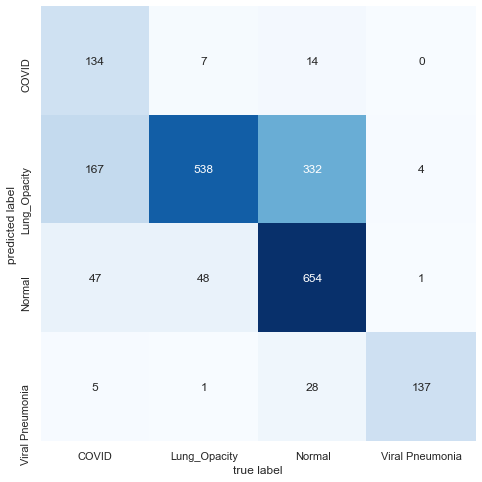

In [47]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred_bm)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices
           )
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

A pesar que podemos ver una tendencia similar a modelo baseline, es fácil ver sutiles diferencias que muestran que este modelo se comporta mejor en general, y en particular mejora el comportamiento de las clases menos representativas, aunque siguen siendo las clases con más miembros las que mejor son clasificadas. La diagonal es siempre el elemento más oscuro si se compara con los demás, tanto en filas como en columnas. Es decir, en la mayoría de casos, estamos clasificando bien las categorías (de ahí el aumento en la exactitud con respecto al modelo baseline). Esto representa una mejoría con respecto al modelo baseline, en el cual la diagonal no siempre era la mejor clasificada, por ende su bajo accuracy.

### Conclusiones finales

Como conclusiones finales, podemos ver que, sin mayor sorpresa, el mejor modelo fue el que se obtuvo por medio del ajuste de hiperparámetros, con un accuracy de 0.69 en test y de 0.72 en train. Esto nos indica, favorablemente, que el modelo no se encuentra haciendo overfitting, pues no hubo gran diferencia en la exactitud obtenida en ambos conjuntos de datos.

Ahora, esperamos que el mejor modelo haya sido este pues es el que más capas tenía. Es posible que, con una mayor cantidad de capas y una mayor cantidad de neuronas por capa, se obtengan mejores resultados de accuracy en entrenamiento. No obstante, debemos cuidarnos de que el modelo empiece a hacer overfitting y, por ende, los resultados de test resulten más desfavorables. Para permitir un poco más de libertad en este sentido, es necesario explorar un espacio de hiperparámetros un poco mayor que, por limitaciones computacionales, no nos fue posible explorar.

Asimismo, es cierto que el preprocesamiento que se hizo no fue más que poner la imagen en escala de grises y aplanarla. Quizá si se hubiese utilizado filtros, Data Augmentation, u otras técnicas más robustas de preprocesamiento, se hubiesen obtenido mejores resultados

Finalmente, en la literatura se reportan valores de exactitud mucho mejores para problemas de clasificación de imágenes si, en lugar de usar una arquitectura de MLP, utilizamos una arquitectura CNN, de red neuronal convolucional. Estas pueden presentar, incluso para pocas capas, exactitudes de más de 90% para ambos train y test; lo cual sobrepasa con creces lo obtenido en este laboratorio. De esta forma, se recomienda para este conjunto de datos lo siguiente: primero, permitir más neuronas por capa y/o capas ocultas (teniendo cuidado de no causar overfitting), realizar un preprocesamiento de imágenes más exhaustivo o considerar una arquitectura de ANN (como CNN) diferente, diseñada especialmente para imágenes.

## Referencias
[1] Coronavirus disease (COVID-19) – World Health Organization. (2021). Retrieved 5 October 2021, from https://www.who.int/emergencies/diseases/novel-coronavirus-2019?gclid=Cj0KCQjwwY-LBhD6ARIsACvT72PqduqyNWdB9YQ3awfqyC9FZ1y5Zy7srhp8wrVgEPPmzW4Jgll_Di8aAiDuEALw_wcB

[2] https://www.linkedin.com/pulse/keras-image-preprocessing-scaling-pixels-training-adwin-jahn/

[3] http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf

[4] https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks

[5] Kurt Hornik (1991) “Approximation Capabilities of Multilayer Feedforward Networks”, Neural Networks, 4(2), 251–257. doi:10.1016/0893-6080(91)90009-T

[6] https://towardsdatascience.com/simplified-math-behind-dropout-in-deep-learning-6d50f3f47275

[7] https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

[8] https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
